## BAGLE fit with PyMC
Goal: use HMC+NUTS to fit a Bagle model.

The main idea for this is to treat the Bagle likelihood function as a 'black box' likelihood, since it is a function that does not use PyMC's distribution format for priors/posteriors (just uses scalars instead). This code should adapt to that to allow such 'black box' functions to be used with PyMC. 
This is currently working, and fits using model.py and model_jax.py work with HMC and PyMC.

TODO: get fits to work with a grad function and model_jax.py, in order to use NUTS and other gradient sampling methods.
- This may be useful for fixing the pytensor Op: https://www.pymc.io/projects/examples/en/latest/howto/wrapping_jax_function.html


- Following example: https://www.pymc.io/projects/examples/en/latest/howto/blackbox_external_likelihood_numpy.html
- Different online learning algorithms: https://bjlkeng.io/posts/bayesian-learning-via-stochastic-gradient-langevin-dynamics-and-bayes-by-backprop/

In [1]:
import arviz as az
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.10.4


In [2]:
from bagle import model_jax
# from bagle import model
import traceback

In [3]:
from bagle import fake_data

In [4]:
fakeData = fake_data.fake_data1(verbose=True)
fakeData

Photometry Parameters: 
t0 =  57000.0
u0 =  -0.12536895749753274
tE =  174.69488771086006
piE_E =  0.008809500605697755
piE_N =  0.03817450262469028
b_sff =  [1.0]
mag_src =  [19.0]
Astrometry Parameters: 
mL =  57000.0
beta =  -0.12536895749753274
dL =  174.69488771086006
dS =  0.008809500605697755
xS0_E =  0.0
xS0_N =  0.0
muL_E =  0.0
muL_N =  -7.0
muS_E =  1.5
muS_N =  -0.5
muRel_E =  1.5
muRel_N =  6.5


({'target': 'NoPar',
  'phot_data': 'sim',
  'ast_data': 'sim',
  'phot_files': ['fake_data_parallax_phot1'],
  'ast_files': ['fake_data_parallax_ast1'],
  't_phot1': array([54062.625, 54063.625, 54064.625, ..., 60143.625, 60144.625,
         60145.625]),
  'mag1': array([18.90819989, 18.97846465, 18.94810036, ..., 19.04711025,
         19.0546362 , 19.07661835]),
  'mag_err1': array([0.05434933, 0.05434933, 0.05434933, ..., 0.05434949, 0.05434949,
         0.05434949]),
  't_ast1': array([54122.625, 54136.625, 54150.625, 54164.625, 54178.625, 54192.625,
         54206.625, 54220.625, 54234.625, 54487.875, 54501.875, 54515.875,
         54529.875, 54543.875, 54557.875, 54571.875, 54585.875, 54599.875,
         54853.125, 54867.125, 54881.125, 54895.125, 54909.125, 54923.125,
         54937.125, 54951.125, 54965.125, 55218.375, 55232.375, 55246.375,
         55260.375, 55274.375, 55288.375, 55302.375, 55316.375, 55330.375,
         55583.625, 55597.625, 55611.625, 55625.625, 55639.625, 

In [5]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [6]:
import jax

## Likelihood function

In [7]:
t_pho = fakeData[0]['t_phot1']
mag_obs = fakeData[0]['mag1']
mag_err_obs = fakeData[0]['mag_err1']

verbose=False
stack_trace=True
if verbose:
  print(t_pho, mag_obs, mag_err_obs)


def my_loglike(t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src):
  priors = (t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src)
  try:
    pspl_model = model_jax.PSPL_Phot_noPar_Param1(t0=t0, u0_amp=u0_amp, tE=tE, piE_E=0.008809500605697755, piE_N=0.03817450262469028, b_sff=[b_sff], mag_src=[mag_src])
    log_likely = pspl_model.log_likely_photometry(t_pho, mag_obs, mag_err_obs, filt_index=0)
    # if use_jax:
    #   return [jax.grad(pspl_model.log_likely_photometry, 1)(
    #     jax.numpy.array(t_pho, float), 
    #     jax.numpy.array(mag_obs, float),
    #     jax.numpy.array(mag_err_obs, float), 
    #     filt_index=0
    #   )]
  except Exception as e:
    if verbose:
      print('t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src')
      print(priors)
      print(e)
      if stack_trace:
        tb = traceback.format_exc()
        print(tb)
    return -100000.0
          
  # if np.isnan(log_likely):
  #   if verbose:
  #     print('t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src')
  #     print(priors)
  #   log_likely =  -10000.0
  
  if verbose:
    print('logl, ', log_likely, type(log_likely), type(priors))
  
  return (log_likely).astype(float)

## Creating a pytensor Op (will convert prior pymc distributions to scalars to work with our likelihood function)

In [8]:
# Define a pytensor Op for our likelihood function, used to account for difference between pm.Distributions and BAGLE scalar priors
class LogLike(pt.Op):

    """
    Specify what type of object will be passed and returned to the Op when it is
    called. In our case we will be passing it a vector of values (the parameters
    that define our model) and returning a single "scalar" value (the
    log-likelihood)
    """

    itypes = [pt.dvector]  # Expects a vector of parameter values when called
    otypes = [pt.dscalar]  # Outputs a single scalar value (the log likelihood)

    def __init__(self, loglike, mag_obs, t_obs, mag_err_obs):
        """
        Initialise the Op with various things that our log-likelihood function
        requires. Below are the things that are needed in this particular
        example.

        Parameters
        ----------
        loglike:
            The log-likelihood (or whatever) function we've defined
        mag_obs:
            The "observed" data that our log-likelihood function takes in
        t_obs:
            The dependent variable (aka 'x') that our model requires
        sigma: (mag_err_obs)
            The noise standard deviation that our function requires.
        """

        # add inputs as class attributes
        self.likelihood = loglike # Likelihood function
        self.mag_obs = mag_obs # Mag_obs
        self.t_obs = t_obs # times
        self.sigma = mag_err_obs # error bars, calculated in bagle, use estimate for testing

    def perform(self, node, inputs, outputs):
        # the method that is used when calling the Op
        (theta,) = inputs  # Priors

        # call the log-likelihood function
        logl = self.likelihood(theta[0], theta[1], theta[2], theta[3], theta[4], theta[5], theta[6])

        outputs[0][0] = np.array(logl)  # output the log-likelihood

## Model fit

In [9]:
'''Photometry Parameters: 
t0 =  57000.0
u0 =  -0.12536895749753274
tE =  174.69488771086006
piE_E =  0.008809500605697755
piE_N =  0.03817450262469028
b_sff =  [1.0]
mag_src =  [19.0]
Astrometry Parameters: 
mL =  57000.0
beta =  -0.12536895749753274
dL =  174.69488771086006
dS =  0.008809500605697755
xS0_E =  0.0
xS0_N =  0.0
muL_E =  0.0
muL_N =  -7.0
muS_E =  1.5
muS_N =  -0.5
muRel_E =  1.5
muRel_N =  6.5'''

'Photometry Parameters: \nt0 =  57000.0\nu0 =  -0.12536895749753274\ntE =  174.69488771086006\npiE_E =  0.008809500605697755\npiE_N =  0.03817450262469028\nb_sff =  [1.0]\nmag_src =  [19.0]\nAstrometry Parameters: \nmL =  57000.0\nbeta =  -0.12536895749753274\ndL =  174.69488771086006\ndS =  0.008809500605697755\nxS0_E =  0.0\nxS0_N =  0.0\nmuL_E =  0.0\nmuL_N =  -7.0\nmuS_E =  1.5\nmuS_N =  -0.5\nmuRel_E =  1.5\nmuRel_N =  6.5'

In [10]:
# create our Op (will convert prior pymc distributions to scalars to work with our likelihood function)
logl = LogLike(my_loglike, mag_obs, t_pho, mag_err_obs)

# use PyMC to sampler from log-likelihood
with pm.Model():
    # set prior distributions for the model
    t0 = pm.Uniform('t0', 55000.0, 59000.0)
    mag_src = pm.Uniform('mag_src', 18.0, 19.5)
    tE = pm.Uniform('tE', 150.0, 180.0)
    u0_amp = pm.Uniform('u0_amp', -0.16, -0.01)
    piE_E = pm.Uniform('piE_E', 0.001, 0.2)
    piE_N = pm.Uniform('piE_N', 0.01, 0.2)
    b_sff = pm.Uniform('b_sff', 0.9, 1.01)

    # convert priors to a tensor vector
    priors = pt.as_tensor_variable([
      t0,
      u0_amp,
      tE,
      piE_E,
      piE_N,
      b_sff,
      mag_src
    ])

    # use a Potential to "call" the Op and include it in the logp computation
    pm.Potential("likelihood", logl(priors))

    # approx = pm.fit(method=pm.sgd(logl(priors)), priors) # might work?

    # Use custom number of draws to replace the HMC based defaults
    idata_mh = pm.sample(1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [t0]
>Slice: [mag_src]
>Slice: [tE]
>Slice: [u0_amp]
>Slice: [piE_E]
>Slice: [piE_N]
>Slice: [b_sff]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 637 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


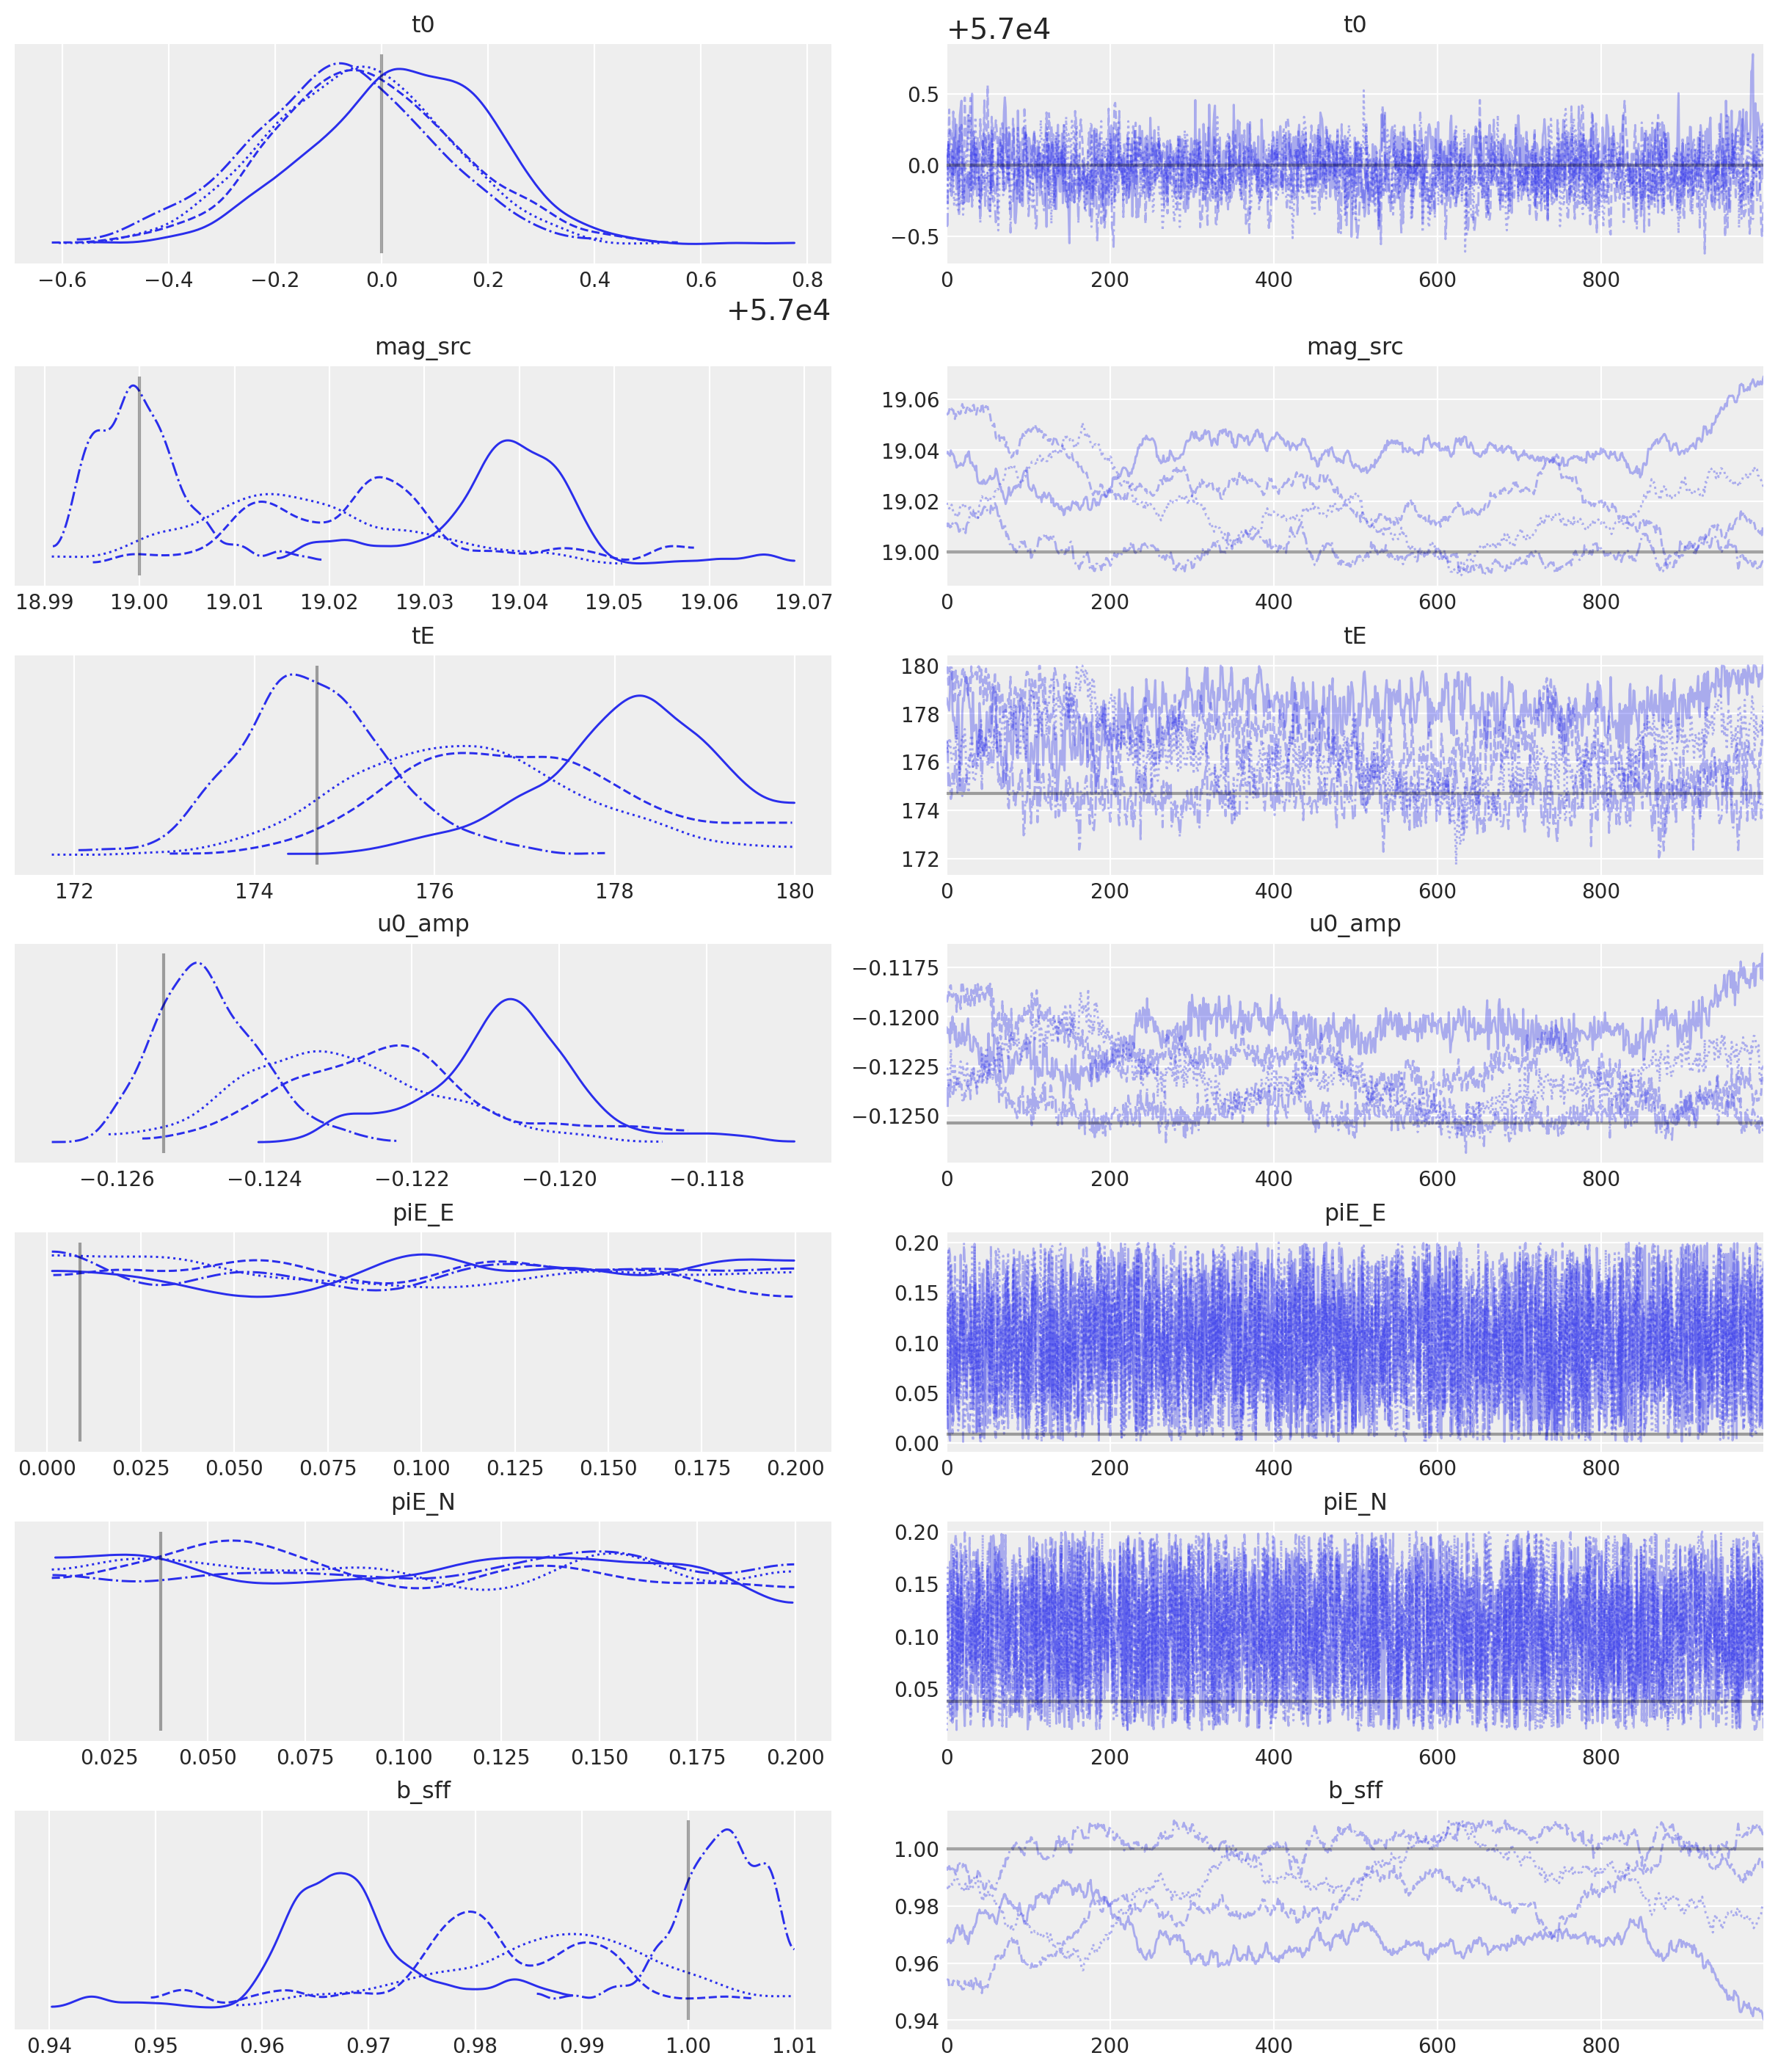

In [11]:
# plot the traces

t0_true = 57000.0
tE_true = 174.69488771086006
piE_E_true = 0.008809500605697755
piE_N_true = 0.03817450262469028
b_sff_true = 1.0
mag_src_true = 19.0
u0_amp_true = -0.12536895749753274

az.plot_trace(idata_mh, lines=[("t0", {}, t0_true), ("tE", {}, tE_true), ("piE_E", {}, piE_E_true), ("piE_N", {}, piE_N_true), ("b_sff", {}, b_sff_true), ("mag_src", {}, mag_src_true), ("u0_amp", {}, u0_amp_true)]);

## Adding a grad function

In [8]:
jax.config.update("jax_traceback_filtering", "off")

In [9]:
class LogLikeGrad(pt.Op):
    itypes = [pt.dvector]
    otypes = [pt.dvector]

    def __init__(self, data, x, sigma):
        self.data = data
        self.x = x
        self.sigma = sigma

    def perform(self, node, inputs, outputs):
        try:
            theta = inputs[0]
            if verbose:
                print('LogLikeGrad perform - theta:', theta)

            grads = [jax.grad(my_loglike, idx) for idx in range(7)]
            grad_values = [grad(*theta) for grad in grads]
            outputs[0][0] = np.array(grad_values, dtype=np.float64)
        except Exception as e:
            print("________ ERRRR 3________", e)
            if stack_trace:
                tb = traceback.format_exc()
                print(tb)
            raise

class LogLikeWithGrad(pt.Op):
    itypes = [pt.dvector]
    otypes = [pt.dscalar]

    def __init__(self, loglike, mag_obs, t_obs, mag_err_obs):
        self.likelihood = loglike
        self.mag_obs = mag_obs
        self.t_obs = t_obs
        self.sigma = mag_err_obs
        self.logpgrad = LogLikeGrad(self.mag_obs, self.t_obs, self.sigma)

    def perform(self, node, inputs, outputs):
        try:
            (theta,) = inputs
            if verbose:
                print('LogLikeWithGrad perform - theta:', theta)

            logl = self.likelihood(*theta)
            outputs[0][0] = np.array(logl, dtype=np.float64)
        except Exception as e:
            print("________ ERRRR 1________", e)
            if stack_trace:
                tb = traceback.format_exc()
                print(tb)
            raise

    def grad(self, inputs, g):
        try:
            (theta,) = inputs
            if verbose:
                print('LogLikeWithGrad grad - theta:', theta)

            grad_val = self.logpgrad(theta)
            return [grad_val * g[0]]
        except Exception as e:
            print("________ ERRRR 2________", e)
            if stack_trace:
                tb = traceback.format_exc()
                print(tb)
            raise

# Create the LogLikeWithGrad instance
logl_grad = LogLikeWithGrad(my_loglike, mag_obs, t_pho, mag_err_obs)

# Use PyMC to sample from the log-likelihood
with pm.Model() as model:
    t0 = pm.Uniform('t0', 55000.0, 59000.0)
    mag_src = pm.Uniform('mag_src', 18.0, 19.5)
    tE = pm.Uniform('tE', 150.0, 180.0)
    u0_amp = pm.Uniform('u0_amp', -0.16, -0.01)
    piE_E = pm.Uniform('piE_E', 0.001, 0.2)
    piE_N = pm.Uniform('piE_N', 0.01, 0.2)
    b_sff = pm.Uniform('b_sff', 0.9, 1.01)

    priors = pt.as_tensor_variable([t0, u0_amp, tE, piE_E, piE_N, b_sff, mag_src])

    pm.Potential("likelihood", logl_grad(priors))

    idata_mh_grad = pm.sample()

# Debugging Output
print(idata_mh_grad)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t0, mag_src, tE, u0_amp, piE_E, piE_N, b_sff]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Visualize Fit with jax

In [ ]:
# plot the traces
az.plot_trace(idata_mh_grad, lines=[("t0", {}, t0_true), ("tE", {}, tE_true), ("piE_E", {}, piE_E_true), ("piE_N", {}, piE_N_true), ("b_sff", {}, b_sff_true), ("mag_src", {}, mag_src_true), ("u0_amp", {}, u0_amp_true)]);